In [1]:
# load packages
import requests
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

In [2]:
# import data
data = pd.read_excel("data.xlsx", sheet_name = "Online Retail")

In [3]:
# check the data
type(data)
data.shape
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
# Clean data:
## 1. Remove NAs
data = data.dropna()
## 2. Remove special symbols:
data['Description'] = data['Description'].replace('"','',regex=True)
data['Description'] = data['Description'].replace('\?','',regex=True)
data['Description'] = data['Description'].replace('\.','',regex=True)

## 3. InvoiceNo: If this code starts with letter 'C', it indicates a cancellation. 
cancelled = data[data.InvoiceNo.astype(str).str.startswith('C')] # find all cancellation entry
cancelled.query('Quantity > 0') # see all quantity belows zero (recognized the pattern)
cancelled_no = set(cancelled.InvoiceNo)
data = data[~data.InvoiceNo.isin(cancelled_no)] # remove all cancelled orders

In [6]:
# Convert InvoiceNo to int:
data.InvoiceNo = data.InvoiceNo.astype(int)
# Convert CustomerID to int:
data.CustomerID = data.CustomerID.astype(int)

In [7]:
# aggregate data by invoice number, CustomerID, Country: item-item
item_df = data.groupby(['InvoiceNo', 'CustomerID', 'Country']).agg(lambda x: tuple(x)).applymap(list).reset_index()


In [8]:
# Convert number of purchase into category: small (<=2) & medium (<=5) & big (else)
#bins = [0, 2, 6, 12, np.inf]
#data['Quantity_Q'] = pd.cut(data['Quantity'], bins, labels = ['Q1', 'Q2', 'Q3', 'Q4'])
#data = data.drop(['Quantity'], axis = 1)

In [9]:
# aggregate data by invoice number, CustomerID, Country: customer-item
customer_df = data.groupby(['CustomerID', 'Country']).agg(lambda x: tuple(x)).applymap(list).reset_index()

In [10]:
#data
#data.groupby('Quantity').count()

In [11]:
# Check to see there is no repeated invoiceNo in item_df
print(len(set(item_df.InvoiceNo)), len(set(data.InvoiceNo))) # set function remove duplicate

18536 18536


In [12]:
# Check to see there is no repeated CustomerID in customer_df
print(len(set(customer_df.CustomerID)), len(set(data.CustomerID)))

4339 4339


In [13]:
# Duplicates of InvoiceNo exists -> find it
#check = data_df.InvoiceNo[data_df.InvoiceNo.duplicated()]
#check
#data_df[data_df.InvoiceNo.isin(check)] # found diff in invoicedate
#check.InvoiceNo = check.InvoiceNo.astype(int).fillna(0)
#check.sort_values('InvoiceNo')

In [14]:
# item_df:
# Pick min date in InvoiceDate
item_df['InvoiceDate'] = item_df['InvoiceDate'].map(lambda x: min(x))
# Order by InvoiceDate:
item_df = item_df.sort_values(by=['InvoiceDate'])

# Convert datetime object to string
import datetime as dt
item_df['InvoiceDate'] = item_df['InvoiceDate'].dt.strftime("%Y/%m/%d %H:%M:%S")

# Split into 20% testing and 8c0% training by order:
cut = round(item_df.shape[0]*0.8)
item_train, item_test = item_df.loc[:cut], item_df.loc[(cut+1):]
print(item_df.shape, item_train.shape, item_test.shape)

# convert dataframe to dict
item_train_dic = item_train.astype(object).to_dict("records")
item_test_dic = item_test.astype(object).to_dict("records")

(18536, 8) (14830, 8) (3706, 8)


In [15]:
item_df

,InvoiceNo,CustomerID,Country,StockCode,Description,Quantity,InvoiceDate,UnitPrice
0,536365,17850,United Kingdom,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...","[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...","[6, 6, 8, 6, 6, 2, 6]",2010/12/01 08:26:00,"[2.55, 3.39, 2.75, 3.39, 3.39, 7.65, 4.25]"
1,536366,17850,United Kingdom,"[22633, 22632]","[HAND WARMER UNION JACK, HAND WARMER RED POLKA...","[6, 6]",2010/12/01 08:28:00,"[1.85, 1.85]"
2,536367,13047,United Kingdom,"[84879, 22745, 22748, 22749, 22310, 84969, 226...","[ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO...","[32, 6, 6, 8, 6, 6, 3, 2, 3, 3, 4, 4]",2010/12/01 08:34:00,"[1.69, 2.1, 2.1, 3.75, 1.65, 4.25, 4.95, 9.95,..."
3,536368,13047,United Kingdom,"[22960, 22913, 22912, 22914]","[JAM MAKING SET WITH JARS, RED COAT RACK PARIS...","[6, 3, 3, 3]",2010/12/01 08:34:00,"[4.25, 4.95, 4.95, 4.95]"
4,536369,13047,United Kingdom,[21756],[BATH BUILDING BLOCK WORD],[3],2010/12/01 08:35:00,[5.95]
5,536370,12583,France,"[22728, 22727, 22726, 21724, 21883, 10002, 217...","[ALARM CLOCK BAKELIKE PINK, ALARM CLOCK BAKELI...","[24, 24, 12, 12, 24, 48, 24, 18, 24, 24, 24, 2...",2010/12/01 08:45:00,"[3.75, 3.75, 3.75, 0.85, 0.65, 0.85, 1.25, 2.9..."
6,536371,13748,United Kingdom,[22086],[PAPER CHAIN KIT 50'S CHRISTMAS ],[80],2010/12/01 09:00:00,[2.55]
7,536372,17850,United Kingdom,"[22632, 22633]","[HAND WARMER RED POLKA DOT, HAND WARMER UNION ...","[6, 6]",2010/12/01 09:01:00,"[1.85, 1.85]"
8,536373,17850,United Kingdom,"[85123A, 71053, 84406B, 20679, 37370, 21871, 2...","[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...","[6, 6, 8, 6, 6, 6, 6, 6, 2, 4, 6, 6, 6, 6, 2, 6]",2010/12/01 09:02:00,"[2.55, 3.39, 2.75, 4.95, 1.06, 1.06, 1.06, 1.0..."
9,536374,15100,United Kingdom,[21258],[VICTORIAN SEWING BOX LARGE],[32],2010/12/01 09:09:00,[10.95]


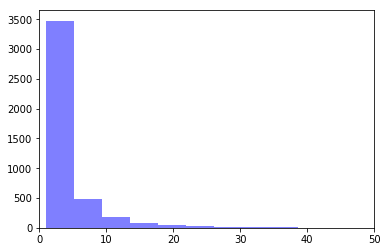

In [16]:
# customer_df:
# Replace InvoiceNo by unique number of purchase
customer_df['PurchaseFreq'] = customer_df['InvoiceNo'].map(lambda x: len(set(x)))
customer_df = customer_df.drop(['InvoiceNo', 'InvoiceDate'], axis = 1)

customer_df['PurchaseFreq'].describe() # 50% -> 2; 75% -> 5

#Plot
%matplotlib inline
num_bins = 50
n, bins, patches = plt.hist(customer_df['PurchaseFreq'], num_bins, facecolor='blue', alpha=0.5)
plt.xlim(0,50)
plt.show()

# Convert number of purchase into category: small (<=2) & medium (<=5) & big (else)
bins = [0, 2, 5, np.inf]
customer_df['PurchaseFreq'] = pd.cut(customer_df['PurchaseFreq'], bins, labels = ['rare', 'middle', 'common'])


In [17]:
customer_df

,CustomerID,Country,StockCode,Description,Quantity,UnitPrice,PurchaseFreq
0,12346,United Kingdom,[23166],[MEDIUM CERAMIC TOP STORAGE JAR],[74215],[1.04],rare
1,12347,Iceland,"[85116, 22375, 71477, 22492, 22771, 22772, 227...","[BLACK CANDELABRA T-LIGHT HOLDER, AIRLINE BAG ...","[12, 4, 12, 36, 12, 12, 12, 12, 12, 12, 4, 4, ...","[2.1, 4.25, 3.25, 0.65, 1.25, 1.25, 1.25, 1.25...",common
2,12348,Finland,"[84992, 22951, 84991, 84991, 21213, 21213, 226...","[72 SWEETHEART FAIRY CAKE CASES, 60 CAKE CASES...","[72, 72, 24, 120, 24, 120, 72, 144, 144, 48, 7...","[0.55, 0.55, 0.55, 0.42, 0.55, 0.42, 0.29, 0.2...",middle
3,12349,Italy,"[23112, 23460, 21564, 21411, 21563, 22131, 221...","[PARISIENNE CURIO CABINET, SWEETHEART WALL TID...","[2, 2, 6, 3, 6, 6, 12, 2, 12, 2, 12, 12, 6, 3,...","[7.5, 9.95, 2.95, 4.25, 2.95, 1.95, 1.65, 8.25...",rare
4,12350,Norway,"[21908, 22412, 79066K, 79191C, 22348, 84086C, ...","[CHOCOLATE THIS WAY METAL SIGN, METAL SIGN NEI...","[12, 12, 10, 12, 24, 6, 12, 12, 12, 12, 12, 12...","[2.1, 2.1, 0.85, 0.85, 0.85, 2.95, 1.65, 1.65,...",rare
5,12352,Norway,"[21380, 22064, 21232, 22646, 22779, 22423, 226...","[WOODEN HAPPY BIRTHDAY GARLAND, PINK DOUGHNUT ...","[6, 12, 12, 12, 4, 3, 3, 3, 3, 3, 3, 6, 12, 12...","[2.95, 1.65, 1.25, 1.45, 4.25, 12.75, 5.95, 9....",common
6,12353,Bahrain,"[37449, 37446, 22890, 37450]","[CERAMIC CAKE STAND + HANGING CAKES, MINI CAKE...","[2, 8, 4, 6]","[9.95, 1.45, 9.95, 2.95]",rare
7,12354,Spain,"[23201, 23204, 23205, 23254, 23255, 23256, 219...","[JUMBO BAG ALPHABET, CHARLOTTE BAG APPLES DESI...","[10, 10, 10, 4, 4, 4, 2, 1, 32, 4, 6, 6, 4, 12...","[2.08, 0.85, 0.85, 4.15, 4.15, 4.15, 7.95, 14....",rare
8,12355,Bahrain,"[22693, 23076, 23077, 22890, 22649, 22423, 850...","[GROW A FLYTRAP OR SUNFLOWER IN TIN, ICE CREAM...","[24, 96, 60, 2, 8, 2, 12, 6, 6, 6, 6, 6, 6]","[1.25, 1.25, 1.25, 9.95, 4.95, 12.75, 1.65, 2....",rare
9,12356,Portugal,"[22138, 21198, 21114, 21199, 21231, 22060, 220...","[BAKING SET 9 PIECE RETROSPOT , WHITE HEART CO...","[24, 48, 40, 48, 72, 12, 24, 24, 48, 24, 12, 6...","[4.25, 0.42, 1.25, 0.42, 1.06, 8.5, 2.95, 1.45...",middle


In [18]:
# Randomly split into 80% testing and 20% training:
customer_df.sample(frac=1).reset_index(drop=True)
cut = round(customer_df.shape[0]*0.8)
customer_train, customer_test = customer_df[:cut], customer_df[cut:]
print(customer_df.shape, customer_train.shape, customer_test.shape)

# convert dataframe to dict
customer_train_dic = customer_train.astype(object).to_dict("records")
customer_test_dic = customer_test.astype(object).to_dict("records")


(4347, 7) (3478, 7) (869, 7)


## Elasticsearch & Kibana:

In [20]:
# defined a fucntion that list out all indices
def get_es_indices():
    r = requests.get("http://elasticsearch:9200/_cat/indices?format=json")
    if r.status_code != 200:
        print("Error listing indices")
        return None
    else:
        indices_full = r.json()  # contains full metadata as a dict
        indices = []  # let's extract the names separately
        for i in indices_full:
            indices.append(i['index'])
        return indices, indices_full
        
indices, indices_full = get_es_indices()
print(indices)

['testindex', 'recipes', '.kibana', 'item_train', 'cust_test', 'item_test', 'purchases', 'citibike_station_update_1', 'cust_train']


In [21]:
# defined a fucntion that create and delete indices
def create_es_index(index, index_config):
    r = requests.put("http://elasticsearch:9200/{}".format(index),
                     json=index_config)
    if r.status_code != 200:
        print("Error creating index")
    else:
        print("Index created")
        

def delete_es_index(index):
    r = requests.delete("http://elasticsearch:9200/{}".format(index))
    if r.status_code != 200:
        print("Error deleting index")
    else:
        print("Index deleted")

In [22]:
# defined a fucntion that send messages
def fling_message(index, doctype, msg):
    r = requests.post("http://elasticsearch:9200/{}/{}".format(index, doctype),
                      json=msg)
    if r.status_code != 201:
        print("Error sending message")
        print(r.status_code)
    else:
        print("message sent")

In [23]:
# delete if exists
indices, indices_full = get_es_indices()
print(indices)
#if 'purchases' in indices:
#    delete_es_index('purchases')
if 'item_test' in indices:
    delete_es_index('item_test')
if 'item_train' in indices:
    delete_es_index('item_train')
if 'cust_test' in indices:
    delete_es_index('cust_test')
if 'cust_train' in indices:
    delete_es_index('cust_train')  

['item_test', 'testindex', 'recipes', '.kibana', 'cust_train', 'purchases', 'citibike_station_update_1', 'cust_test', 'item_train']
Index deleted
Index deleted
Index deleted
Index deleted


In [24]:
#item
# create index config
index_config = {
    "mappings": {
        "purchase": {  # document TYPE
            "properties": {
                "InvoiceNo": {"type": "integer", "index": "not_analyzed"},
                "CustomerID":{"type": "integer", "index": "not_analyzed"},
                "Country": {"type": "string", "index": "not_analyzed"},
                "StockCode": {"type": "string", "index": "not_analyzed"},
                "Description": {"type": "string", "index": "not_analyzed"},
                "Quantity": {"type": "string", "index": "not_analyzed"},
                "InvoiceDate": {"type": "date", "format": "yyyy/MM/dd HH:mm:ss", "index": "not_analyzed"}, # format option
                "UnitPrice": {"type": "string", "index": "not_analyzed"},   
            }
        }
    }
}

#create_es_index('purchases', index_config)
create_es_index('item_test', index_config)
create_es_index('item_train', index_config)

Index created
Index created


In [25]:
# item
# fling the test messages:
for msg in item_test_dic:
    #print(msg)
    fling_message('item_test', 'purchase', msg)

# fling the train messages:
for msg in item_train_dic:
    #print(msg)
    fling_message('item_train', 'purchase', msg)

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

In [26]:
#customer
# create index config
index_config = {
    "mappings": {
        "purchase": {  # document TYPE
            "properties": {
                "CustomerID":{"type": "integer", "index": "not_analyzed"},
                "Country": {"type": "string", "index": "not_analyzed"},
                "StockCode": {"type": "string", "index": "not_analyzed"},
                "Description": {"type": "string", "index": "not_analyzed"},
                "Quantity": {"type": "string", "index": "not_analyzed"},
                "UnitPrice": {"type": "string", "index": "not_analyzed"},
                "Purchase_Freq": {"type": "string", "index": "not_analyzed"}
            }
        }
    }
}

#create_es_index('purchases', index_config)
create_es_index('cust_test', index_config)
create_es_index('cust_train', index_config)

Index created
Index created


In [27]:
#customer
# fling the test messages:
for msg in customer_test_dic:
    #print(msg)
    fling_message('cust_test', 'purchase', msg)

# fling the train messages:
for msg in customer_train_dic:
    #print(msg)
    fling_message('cust_train', 'purchase', msg)

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent
message sent

## Item-Item Recommender:

In [23]:
def execute_es_query(index, query):
    r = requests.get("http://elasticsearch:9200/{}/_search".format(index),
                     json=query)
    if r.status_code != 200:
        print("Error executing query")
        return None
    else:
        return r.json()

In [23]:
def item_model(item, size):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "filter": [
                    {"term": {"Description": item}},
                ]
            }
        },
        "aggs": {
            "highly_correlated_words": {
                "significant_terms": {
                    "field": "Description",
                    "exclude": item,
                    "min_doc_count": 1,
                    "size": size,
                }
            }
        }
    }
    
    return execute_es_query('item_train', query)

In [25]:
item_rate = []
item_missing = []
item_right_items = []

for index, row in item_test.iterrows():
    items = row['Description']
    size = len(items) - 1
    ratings = []
    
    if size > 0:
        for item in items:
            try:
                res = item_model(item, size)
                bucket = res['aggregations']['highly_correlated_words']['buckets']
                predict_items = [item['key'] for item in bucket]
                actual_items = list(set(items)-set(item))
                
                item_right_items.append((item, (set(actual_items) & set(predict_items))))
                new_rate = (len(set(actual_items) & set(predict_items)))/len(actual_items)
                ratings.append(round(new_rate,2))
            except:
                ratings.append(0)
                item_missing.append(item)

        item_rate.append(np.mean(ratings))
    else:
        item_rate.append("skip")

In [40]:
#item_missing #zero instance where recommender doesn't work.
#item_rate
#item_rate.count('skip')/len(item_rate) # 6.7% customers only purchased one item -> not predictable
#num_rate = [x for x in item_rate if not isinstance(x, str)] 
#np.min(num_rate) # 0% accuracy
#np.max(num_rate) #75% accuracy
#np.mean(num_rate) #8.7% accuracy
item_right_items # give the matches: (input item, [matches])

[('16 PIECE CUTLERY SET PANTRY DESIGN', set()),
 ('BISCUIT TIN VINTAGE CHRISTMAS',
  {'6 GIFT TAGS VINTAGE CHRISTMAS ',
   '60 CAKE CASES VINTAGE CHRISTMAS',
   "BOX OF 6 MINI 50'S CRACKERS",
   'BOX OF 6 MINI VINTAGE CRACKERS',
   "JUMBO BAG 50'S CHRISTMAS ",
   'JUMBO BAG VINTAGE CHRISTMAS ',
   "PAPER CHAIN KIT 50'S CHRISTMAS ",
   'PAPER CHAIN KIT VINTAGE CHRISTMAS',
   'RED SPOT PAPER GIFT BAG',
   'ROLL WRAP VINTAGE CHRISTMAS',
   'SET OF 20 VINTAGE CHRISTMAS NAPKINS',
   'VINTAGE CHRISTMAS GIFT BAG LARGE ',
   'VINTAGE CHRISTMAS PAPER GIFT BAG'}),
 ("BOX OF 6 MINI 50'S CRACKERS",
  {' RED SPOT GIFT BAG LARGE',
   "6 GIFT TAGS 50'S CHRISTMAS ",
   '6 GIFT TAGS VINTAGE CHRISTMAS ',
   '60 CAKE CASES VINTAGE CHRISTMAS',
   'BISCUIT TIN VINTAGE CHRISTMAS',
   'BOX OF 6 MINI VINTAGE CRACKERS',
   "JUMBO BAG 50'S CHRISTMAS ",
   "PACK OF 12 50'S CHRISTMAS TISSUES",
   "PAPER CHAIN KIT 50'S CHRISTMAS ",
   'PAPER CHAIN KIT VINTAGE CHRISTMAS',
   'RED SPOT PAPER GIFT BAG',
   "ROLL WRAP

In [59]:
# Convert item_right_items:
item_right_df = pd.DataFrame(item_right_items, columns = ["item_input", "accurate_predict"])
item_right_df

,item_input,accurate_predict
0,16 PIECE CUTLERY SET PANTRY DESIGN,{}
1,BISCUIT TIN VINTAGE CHRISTMAS,"{6 GIFT TAGS VINTAGE CHRISTMAS , JUMBO BAG VIN..."
2,BOX OF 6 MINI 50'S CRACKERS,"{6 GIFT TAGS VINTAGE CHRISTMAS , ROLL WRAP 50'..."
3,BOX OF 6 MINI VINTAGE CRACKERS,"{6 GIFT TAGS VINTAGE CHRISTMAS , JUMBO BAG VIN..."
4,JUMBO BAG VINTAGE CHRISTMAS,"{6 GIFT TAGS VINTAGE CHRISTMAS , BISCUIT TIN V..."
5,JUMBO BAG 50'S CHRISTMAS,"{6 GIFT TAGS VINTAGE CHRISTMAS , JUMBO BAG VIN..."
6,RED SPOT GIFT BAG LARGE,"{6 GIFT TAGS VINTAGE CHRISTMAS , ROLL WRAP 50'..."
7,VINTAGE CHRISTMAS GIFT BAG LARGE,"{6 GIFT TAGS VINTAGE CHRISTMAS , JUMBO BAG VIN..."
8,POPCORN HOLDER,{PAPER CHAIN KIT 50'S CHRISTMAS }
9,PAPER CHAIN KIT VINTAGE CHRISTMAS,"{6 GIFT TAGS VINTAGE CHRISTMAS , JUMBO BAG VIN..."


## User-Item Recommender:

In [60]:
# Model with purchase behavior filter
def customer_model(location, purchase_freq, item, size):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "filter": [
                    {"term":{"Description": item}},
                    {"term":{"Country": location}},
                    {"term":{"PurchaseFreq": purchase_freq}}
                ]
            }
        },
        "aggs": {
            "highly_correlated_words": {
                "significant_terms": {
                    "field": "Description",
                    "exclude": item,
                    "min_doc_count": 1,
                    "size": size,
                }
            }
        }
    }

    return execute_es_query('cust_train', query)

In [61]:
cust_rate = []
cust_missing = []
cust_right_items = []

for index, row in customer_test.iterrows():
    location = row['Country']
    purchase_freq = row['PurchaseFreq']
    items = row['Description']
    size = len(items) - 1
    ratings = []
    
    if size > 0:
        for item in items:
            try:
                res = customer_model(location, purchase_freq, item, size)
                bucket = res['aggregations']['highly_correlated_words']['buckets']
                predict_items = [item['key'] for item in bucket]
                actual_items = list(set(items)-set(item))
                
                cust_right_items.append((purchase_freq, item, (set(actual_items) & set(predict_items))))
                new_rate = (len(set(actual_items) & set(predict_items)))/len(actual_items)
                ratings.append(round(new_rate,2))
            except:
                ratings.append(0)
                cust_missing.append(item)

        cust_rate.append(np.mean(ratings))
    else:
        cust_rate.append("skip")

In [66]:
#cust_missing #zero instance where recommender doesn't work.
#cust_rate
#cust_rate.count('skip')/len(cust_rate) # 2.6% customers only purchased one item -> not predictable
#num_rate = [x for x in cust_rate if not isinstance(x, str)] 
#np.min(num_rate) # 0% accuracy
#np.max(num_rate) #55.6% accuracy
#np.mean(num_rate) #2.9% accuracy
#cust_right_items

0.026467203682393557